<a href="https://colab.research.google.com/github/christianadriano/PCA_AquacultureSystem/blob/master/PCA_KMeans_Environment_Carcinicultura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd #tables for data wrangling
import numpy as np #basic statistical methods 
import io #for uploading data

#Manual option
from google.colab import files
uploaded = files.upload() #choose file dados_relativizados_carcinicultura.csv



Saving dados_relativizados_centralizados_carcinicultura.csv to dados_relativizados_centralizados_carcinicultura (1).csv


In [ ]:
#Upload data from cvs file
df = pd.read_csv(io.StringIO(uploaded['dados_relativizados_centralizados_carcinicultura.csv'].decode('utf-8'))) 
print(df)

In [ ]:
column_names = df.columns
#Select fatores Ambientais 
feature_names = [name for name in column_names if name.startswith("A")] 

#feature_names = list(df.columns["A2_DA":"A4_EUC"])
#print(feature_names)
list_names = ['cultivo'] + feature_names
df_cultivo = df[list_names]
df_cultivo.head()



In [11]:
#Look at correlations 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_cultivo.corr()

# using a styled panda's dataframe from https://stackoverflow.com/a/42323184/1215012
cmap = 'coolwarm'

def magnify():
    return [dict(selector="th", props=[("font-size", "7pt")]),
            dict(selector="td", props=[('padding', "0em 0em")]),
            dict(selector="th:hover", props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover", 
                 props=[('max-width', '200px'), ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())



,A2_DA,A3_UE,A5_UN,A6_UF,A7_EUE,A8_EUN,A9_EUF,A11_PEPN,A12_PPO,A19_AF,A20_AMO,A22_REC,A1_PRC,A2_PRN,A3_PRF,A4_EUC
A2_DA,1.00,-0.35,0.29,-0.54,-0.13,0.08,0.01,0.65,0.41,0.22,0.79,0.15,-0.22,-0.14,-0.46,0.20
A3_UE,-0.35,1.00,-0.66,0.49,-0.18,-0.29,-0.60,-0.53,-0.09,-0.26,-0.42,0.14,0.24,0.18,0.12,0.07
A5_UN,0.29,-0.66,1.00,-0.29,-0.24,0.29,0.29,0.33,-0.05,0.15,0.13,-0.08,-0.03,0.20,0.09,0.31
A6_UF,-0.54,0.49,-0.29,1.00,0.36,-0.36,-0.21,-0.51,0.13,-0.32,-0.47,0.12,0.24,0.23,0.35,-0.46
A7_EUE,-0.13,-0.18,-0.24,0.36,1.00,-0.14,0.55,0.22,0.43,0.08,0.08,-0.10,-0.21,-0.14,-0.19,-0.91
A8_EUN,0.08,-0.29,0.29,-0.36,-0.14,1.00,0.60,0.04,0.16,-0.37,-0.12,-0.73,-0.75,-0.66,-0.63,0.48
A9_EUF,0.01,-0.60,0.29,-0.21,0.55,0.60,1.00,0.24,0.33,-0.08,0.10,-0.59,-0.63,-0.44,-0.46,-0.25
A11_PEPN,0.65,-0.53,0.33,-0.51,0.22,0.04,0.24,1.00,0.50,0.71,0.66,-0.13,-0.38,-0.01,-0.38,-0.05
A12_PPO,0.41,-0.09,-0.05,0.13,0.43,0.16,0.33,0.50,1.00,0.28,0.54,-0.47,-0.70,-0.39,-0.58,-0.16
A19_AF,0.22,-0.26,0.15,-0.32,0.08,-0.37,-0.08,0.71,0.28,1.00,0.55,0.02,-0.02,0.26,-0.01,-0.07


In [ ]:
#smaller chart
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')

In [ ]:
#check which ones are statiscally significant
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

p_values = calculate_pvalues(df_cultivo)


In [35]:
def highlight_significant(val):
    '''
    highlight in blue only the statistically significant cells
    '''
    color = 'blue' if val < 0.05 else 'grey'
    return 'color: %s' % color

p_values.style.applymap(highlight_significant)

,A2_DA,A3_UE,A5_UN,A6_UF,A7_EUE,A8_EUN,A9_EUF,A11_PEPN,A12_PPO,A19_AF,A20_AMO,A22_REC,A1_PRC,A2_PRN,A3_PRF,A4_EUC
A2_DA,0.000000,0.238700,0.335900,0.054200,0.669000,0.783800,0.976300,0.015900,0.167800,0.465700,0.001300,0.632600,0.474600,0.643900,0.113200,0.517000
A3_UE,0.238700,0.000000,0.013900,0.085700,0.551700,0.338900,0.030500,0.064000,0.772800,0.398600,0.152400,0.647800,0.431100,0.545800,0.703300,0.814600
A5_UN,0.335900,0.013900,0.000000,0.337500,0.437500,0.333300,0.329500,0.272100,0.882300,0.625200,0.677100,0.797500,0.913000,0.511300,0.758500,0.301200
A6_UF,0.054200,0.085700,0.337500,0.000000,0.225800,0.221500,0.498600,0.073900,0.665000,0.282500,0.104100,0.700500,0.421000,0.457400,0.236400,0.117700
A7_EUE,0.669000,0.551700,0.437500,0.225800,0.000000,0.645600,0.054000,0.467800,0.139600,0.797100,0.797800,0.749800,0.483400,0.660100,0.537500,0.000000
A8_EUN,0.783800,0.338900,0.333300,0.221500,0.645600,0.000000,0.031000,0.904900,0.609900,0.211900,0.691500,0.004400,0.002900,0.013200,0.021900,0.093800
A9_EUF,0.976300,0.030500,0.329500,0.498600,0.054000,0.031000,0.000000,0.421800,0.267400,0.787200,0.747100,0.035200,0.021100,0.129800,0.114200,0.409400
A11_PEPN,0.015900,0.064000,0.272100,0.073900,0.467800,0.904900,0.421800,0.000000,0.081400,0.006800,0.014100,0.682700,0.196200,0.964400,0.196500,0.860800
A12_PPO,0.167800,0.772800,0.882300,0.665000,0.139600,0.609900,0.267400,0.081400,0.000000,0.361600,0.057300,0.105600,0.007600,0.189800,0.036700,0.591600
A19_AF,0.465700,0.398600,0.625200,0.282500,0.797100,0.211900,0.787200,0.006800,0.361600,0.000000,0.051800,0.952200,0.950900,0.394400,0.961600,0.828900


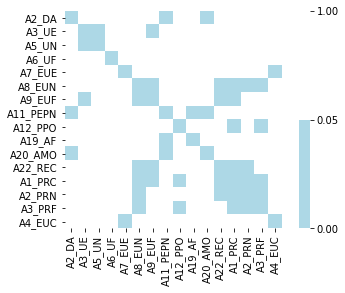

In [40]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

np.random.seed(101)
zvals = np.random.rand(100, 100) * 10

# make a color map of fixed colors
cmap_discrete = colors.ListedColormap(['lightblue', 'white'])
bounds=[0,0.05,1]
norm_binary = colors.BoundaryNorm(bounds, cmap_discrete.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(zvals, interpolation='nearest', origin='lower',
                    cmap=cmap_discrete, norm=norm_binary)

sns.heatmap(p_values, xticklabels=p_values.columns, yticklabels=p_values.columns, cmap=cmap_discrete, norm=norm_binary)

In [ ]:
#Normalize the data to have MEAN==0
from sklearn.preprocessing import StandardScaler

x = df_cultivo.iloc[:,1:].values
x = StandardScaler().fit_transform(x) # normalizing the features
#print(x)


In [ ]:
#Run PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_cultivo[['cultivo']]], axis = 1)

['M. rosenbergii - Espirito Santo-'
 'P. vannamei - Sergipe - Semi intensivo' 'L. vannamei - Aquafort'
 'L. vannamei - Northern' 'L. vannamei - Aquacrusta' 'L. vannamei - HM'
 'L. vannamei - Ilha' 'L. vannamei - Carpixe' 'L. vannamei - Marinus'
 'L. vannamei - Aquabrasilis' 'L. vannamei - Aquarium - baixa densid.'
 'L. vannamei - Aquarium - alta densis'
 'L. vannamei - Aquarium-  bifasico']


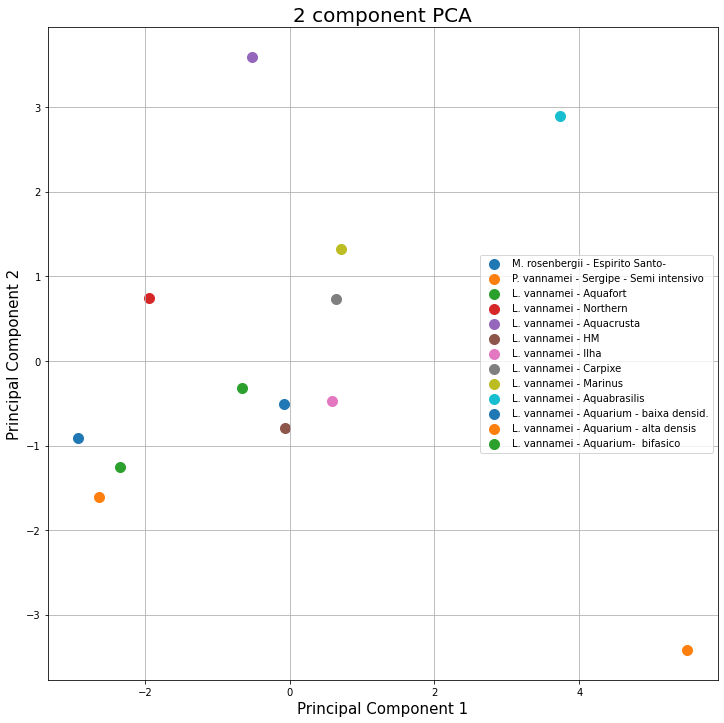

In [ ]:
#Visualize results of PCA
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()
print(targets)
for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , s = 100)
   
#for names in feature_names:  
#    ax.annotate(txt, (z[i], y[i]))

ax.legend(targets)
ax.grid()

In [ ]:
variance_list =pca.explained_variance_ratio_
print("variance explained by each component:", variance_list)
print("total variance explained:", sum(variance_list))


variance explained by each component: [0.34023213 0.20209521]
total variance explained: 0.5423273442182176


In [ ]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'cultivo': targets,  'pc1':list(principalComponents[:,0]), 'pc2': list(principalComponents[:,1])}, columns=['cultivo', 'pc1','pc2'])
#df_clustering

In [ ]:
df_clustering.iloc[:,2]
#df_clustering.iloc[:,1]

0    -0.073283
1     5.490187
2    -0.658878
3    -1.941160
4    -0.526917
5    -0.062581
6     0.586027
7     0.638037
8     0.703847
9     3.736575
10   -2.919138
11   -2.634247
12   -2.338471
Name: pc1, dtype: float64

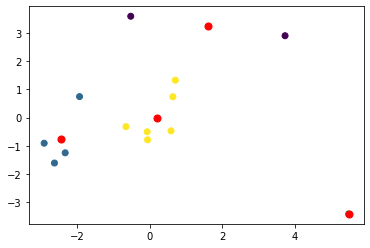

In [ ]:
#Find clusters 
from sklearn.cluster import KMeans
#4 clusters
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

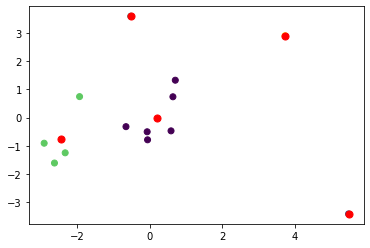

In [ ]:
#5 clusters
model = KMeans(5)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 


In my view, we have two large clusters and three outliers, as the graph above shows.

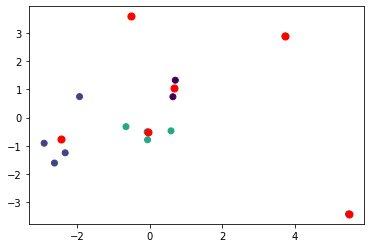

In [ ]:
#6 clusters
model = KMeans(6)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

#7 clusters

In [ ]:
#Find distances among clusters